# Коэффициент восстановления золота из золотосодержащей руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:
1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Подготовка данных

### Откройте файлы и изучите их

In [44]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler


METALS = ['au', 'ag', 'pb']
CONCENTRATE_METRICS = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']
RANDOM_STATE = 12345
TARGETS = ['rougher.output.recovery', 'final.output.recovery']

In [46]:
train_df = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test_df = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full_df = pd.read_csv('/datasets/gold_recovery_full_new.csv')

Training Set - General column information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol           

None

Training Set - Number of duplicates: 0

Training Set - Percentage of missing values in columns:


,number_of_missing,percent_of_missing
secondary_cleaner.output.tail_sol,1605,11.34
rougher.state.floatbank10_e_air,436,3.08
rougher.input.floatbank11_xanthate,428,3.02
primary_cleaner.output.concentrate_sol,286,2.02
secondary_cleaner.state.floatbank2_a_air,217,1.53
...,...,...
rougher.state.floatbank10_a_level,1,0.01
rougher.state.floatbank10_b_air,1,0.01
rougher.state.floatbank10_b_level,1,0.01
rougher.state.floatbank10_c_air,1,0.01


Test Set - General column information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5

None

Test Set - Number of duplicates: 0

Test Set - Percentage of missing values in columns:


,number_of_missing,percent_of_missing
rougher.input.floatbank11_xanthate,25,0.47
rougher.input.feed_sol,21,0.40
secondary_cleaner.state.floatbank3_a_air,9,0.17
rougher.input.floatbank11_sulfate,8,0.15
primary_cleaner.input.depressant,5,0.09
rougher.input.floatbank10_sulfate,5,0.09
primary_cleaner.input.sulfate,4,0.08
primary_cleaner.input.xanthate,4,0.08
rougher.input.feed_rate,3,0.06
secondary_cleaner.state.floatbank2_a_air,3,0.06


Full Data - General column information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol              

None

Full Data - Number of duplicates: 0

Full Data - Percentage of missing values in columns:


,number_of_missing,percent_of_missing
secondary_cleaner.output.tail_sol,1748,8.99
rougher.input.floatbank11_xanthate,453,2.33
rougher.state.floatbank10_e_air,436,2.24
primary_cleaner.output.concentrate_sol,370,1.90
secondary_cleaner.state.floatbank2_a_air,220,1.13
...,...,...
rougher.state.floatbank10_a_level,1,0.01
rougher.state.floatbank10_b_air,1,0.01
rougher.state.floatbank10_b_level,1,0.01
rougher.state.floatbank10_c_air,1,0.01


In [3]:
data = [train_df, test_df, full_df]
data_names = ['Обучающая выборка', 'Тестовая выборка', 'Исходные данные']

def percent_of_missing_values(df):
    number_of_missing = df.isnull().sum()
    missing_value_df = pd.DataFrame({
        'number_of_missing': number_of_missing,
        'percent_of_missing': round((number_of_missing / len(df)) * 100, 2)
    })
    return missing_value_df[missing_value_df['number_of_missing'] > 0]

for df, name in zip(data, data_names):
    print(name, '-', 'Общая информация о столбцах:', end='\n\n')
    display(df.info())
    print(f'{name} - Количество дубликатов: {df.duplicated().sum()}', end='\n\n')
    print(name, '-', 'Процент пропущенных значений в столбцах:', end='\n')
    display(percent_of_missing_values(df).sort_values('percent_of_missing', ascending=False))

Обучающая выборка - Общая информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol     

None

Обучающая выборка - Количество дубликатов: 0

Обучающая выборка - Процент пропущенных значений в столбцах:


,number_of_missing,percent_of_missing
secondary_cleaner.output.tail_sol,1605,11.34
rougher.state.floatbank10_e_air,436,3.08
rougher.input.floatbank11_xanthate,428,3.02
primary_cleaner.output.concentrate_sol,286,2.02
secondary_cleaner.state.floatbank2_a_air,217,1.53
...,...,...
rougher.state.floatbank10_a_level,1,0.01
rougher.state.floatbank10_b_air,1,0.01
rougher.state.floatbank10_b_level,1,0.01
rougher.state.floatbank10_c_air,1,0.01


Тестовая выборка - Общая информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_a

None

Тестовая выборка - Количество дубликатов: 0

Тестовая выборка - Процент пропущенных значений в столбцах:


,number_of_missing,percent_of_missing
rougher.input.floatbank11_xanthate,25,0.47
rougher.input.feed_sol,21,0.40
secondary_cleaner.state.floatbank3_a_air,9,0.17
rougher.input.floatbank11_sulfate,8,0.15
primary_cleaner.input.depressant,5,0.09
rougher.input.floatbank10_sulfate,5,0.09
primary_cleaner.input.sulfate,4,0.08
primary_cleaner.input.xanthate,4,0.08
rougher.input.feed_rate,3,0.06
secondary_cleaner.state.floatbank2_a_air,3,0.06


Исходные данные - Общая информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol       

None

Исходные данные - Количество дубликатов: 0

Исходные данные - Процент пропущенных значений в столбцах:


,number_of_missing,percent_of_missing
secondary_cleaner.output.tail_sol,1748,8.99
rougher.input.floatbank11_xanthate,453,2.33
rougher.state.floatbank10_e_air,436,2.24
primary_cleaner.output.concentrate_sol,370,1.90
secondary_cleaner.state.floatbank2_a_air,220,1.13
...,...,...
rougher.state.floatbank10_a_level,1,0.01
rougher.state.floatbank10_b_air,1,0.01
rougher.state.floatbank10_b_level,1,0.01
rougher.state.floatbank10_c_air,1,0.01


**Вывод**

В обучающей выборке 87 столбцов и 14149 объектов. Типы данных в столбцах совпадают с их природой, кроме колонки `date`. В 62 столбцах есть пропуски, больше всего в колонке `secondary_cleaner.output.tail_sol` - 11%, тоесть нам не хватает данных о количество солей в отвальных хвостах после второго этапа очищения. Пропусков в остальных столбцах менше 3%. Дубликатов в таблице нет.

В тестовой выборке 53 столбца и 5290 объектов. Неправильный тип данных в столбце `date`. В 12 колонках есть пропущенные значения, но их процент меньше 0.5. Дубликатов в таблице нет.

В исходные данных 87 столбцов и 19439 объектов (что верно, и равно сумме количества объектов в обучающей и тестовой выборках). Тип в столбце `date` также не соответствует деятельности. Дубликатов в таблице нет. Пропуска есть в 63 столбцах. Интересный факт, что количественно пропусков в исходных данных больше, чем суммарно в двух выборках. Это наталкивает на мысль, что данные в выборках могут уже быть как-то обработаны или заполнены.

Мы вернемся к этим выводам на этапе предобработки данных.

### Расчет эффективности обогащения

Проверим, что эффективность обогащения рассчитана правильно, вычислим её на обучающей выборке для признака `rougher.output.recovery`.

\begin{align}
Recovery = \frac{C(F - T)} {F(C - T)} * 100%
\end{align}

Для `rougher.output.recovery`:
- С - `rougher.output.concentrate_au`
- F - `rougher.input.feed_au`
- T - `rougher.output.tail_au`

In [4]:
def get_rougher_recovery(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    return ((c * (f - t)) / (f * (c - t))) * 100

rougher_recovery_calc = train_df.apply(get_rougher_recovery, axis = 1)

Найдем MAE между нашими расчётами и значением признака.

In [5]:
print(f"MAE равно {mean_absolute_error(train_df['rougher.output.recovery'], rougher_recovery_calc)}")

MAE равно 9.73512347450521e-15


**Вывод**
Средняя абсолютная ошибка практически равна нулю, это означает, что эффективность обогащения рассчитана правильно

### Признаки, недоступные в тестовой выборке

In [6]:
train_cols = train_df.columns
test_cols = test_df.columns

print([col for col in train_cols if col not in test_cols])

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tai

Но мы добавим целевые показатели в тестовый датасет.

In [7]:
test_df = test_df.merge(full_df[[*TARGETS, 'date']], on='date', how='left')

**Вывод**
В тестовой выборке нам недоступно 35 признаков. Они все являются онлайн-метриками, которые мы можем получить только в процессе работы системы (т.е. после после (`output`) таких процессов как флотация (`rougher`) и очистки (`primary_cleaner`, `secondary_cleaner`), перед (`input`) первым и вторым этапами очистки (`primary_cleaner`, `secondary_cleaner`) и в конце (`final`)). Наша модель не сможет использовать эти признаки для прогнозирования, но пока мы оставим эти столбцы в таблице для анализа данных.

### Предобработка данных
Так как мы знаем, что исходный датасет содержит больше пропусков, то будем в дальнейшем использовать только данные обучающей и тестовой выборок и проводить предобработку тольео для этих данных.

**Замена типа данных**


In [8]:
data = [train_df, test_df]

date_format = '%Y-%m-%d %H:%M:%S'
for df in data:
    df['date'] = pd.to_datetime(df['date'], format=date_format)

**Обработка пропусков**

Мы знаем, что соседние по времени параметры часто похожи, поэтому для заполнения пропуска в k-строке будем брать данные с k-1 строки.

In [9]:
for df in data:
    df.fillna(method='ffill', inplace=True)

## Анализ данных

### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

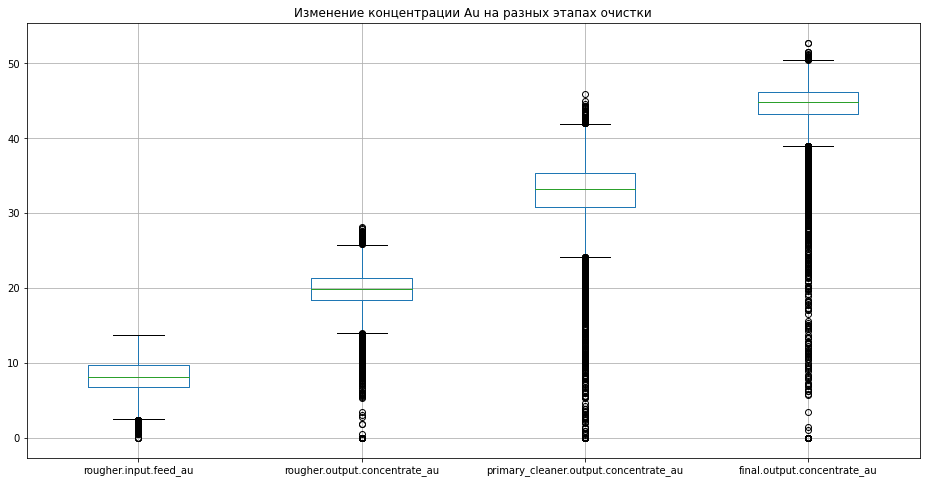

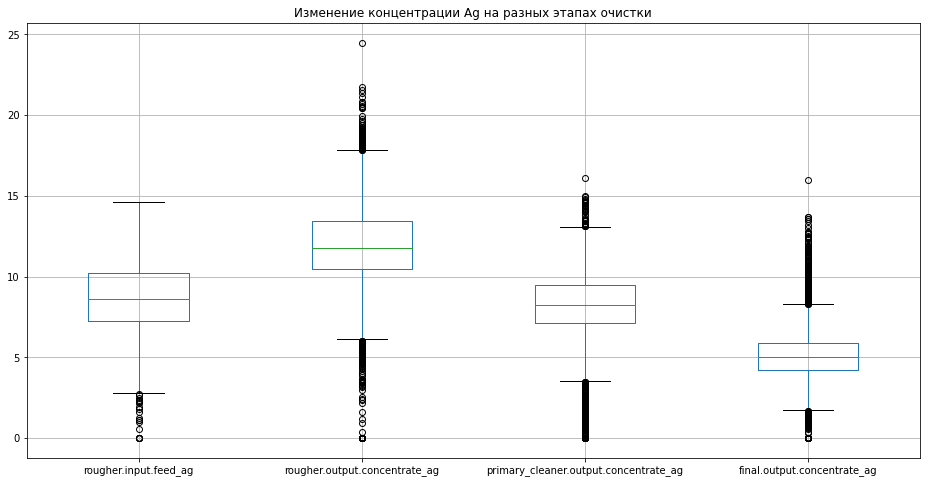

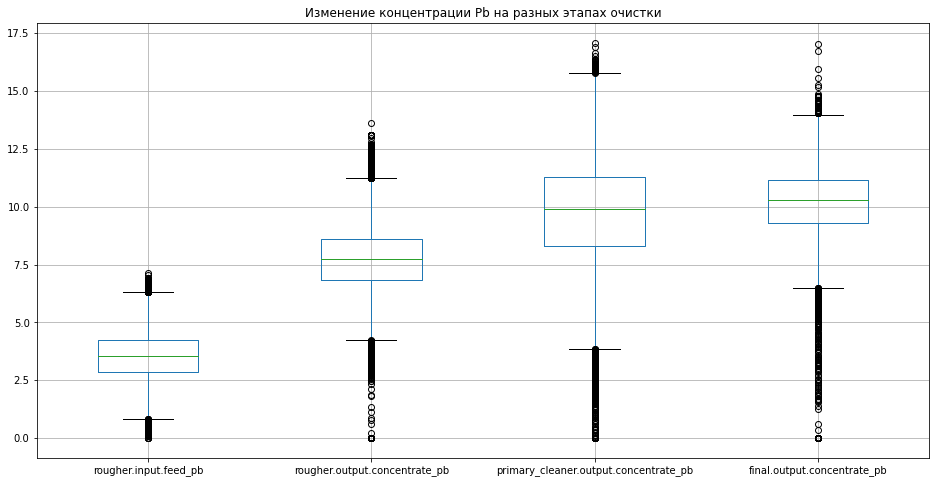

In [10]:
full_data = pd.concat([train_df, test_df])

for metal in METALS:
    metrics = [f'{metric}_{metal}' for metric in CONCENTRATE_METRICS]
    full_data[metrics].boxplot(figsize=(16, 8))
    plt.title(f'Изменение концентрации {metal.capitalize()} на разных этапах очистки')
    plt.show()

**Вывод**

 - Концентрация золота увеличивается с каждым новым этапом очистки, что логично, так как цель флотации и очисток - увеличить концентрацию золота
 - Концентрация серебра, хотя и увеличилась после флотации, но на финальном этапе медиана достигает своего минимума. Заметно уменьшение разброса значений.
 - Концентрация свинца также увеличивается, как и золота. Но после первичной очистки мы можем заметить большой разброс значений.

### Распределения размеров гранул сырья

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

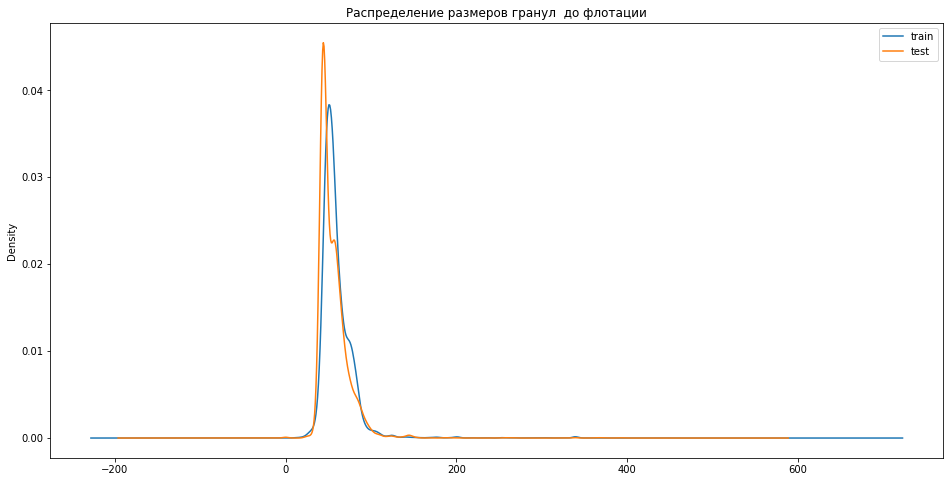

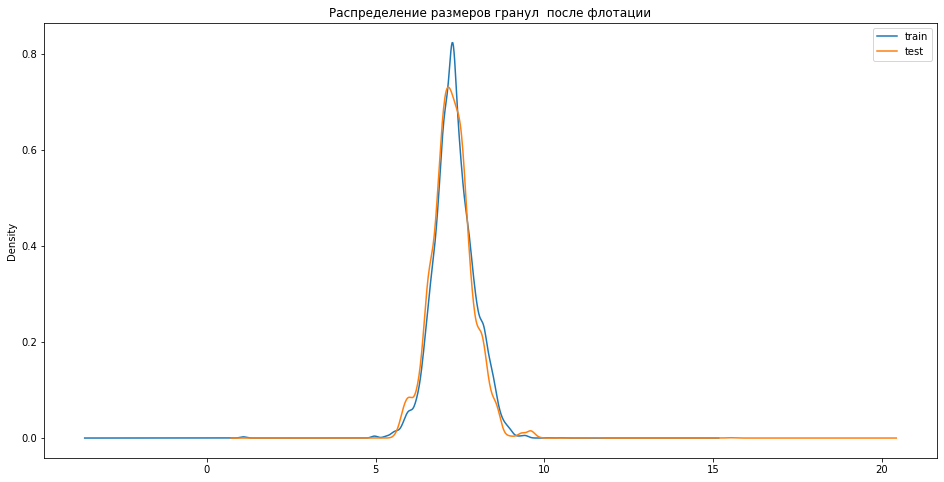

In [11]:
cols = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

for col, title in zip(cols, ['до флотации', 'после флотации']):
    for df, name in zip(data, ['train', 'test']):
        df[col].plot(kind='kde', figsize=(16, 8), label=name, legend=True)
    plt.title(f'Распределение размеров гранул  {title}')
    plt.show()

**Вывод**

Распределение размеров гранул до флотации в обучающей и тестовой выбрках похожи между собой, и напоминают нормальное со смещением влево.

Размеры гранул после флотации распределены нормально для  обучающей и тестовой выбрки.

### Cуммарная концентрация всех веществ

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

<AxesSubplot:title={'center':'Гистограмма распределения концентраций на разных этапах очистки'}, ylabel='Frequency'>

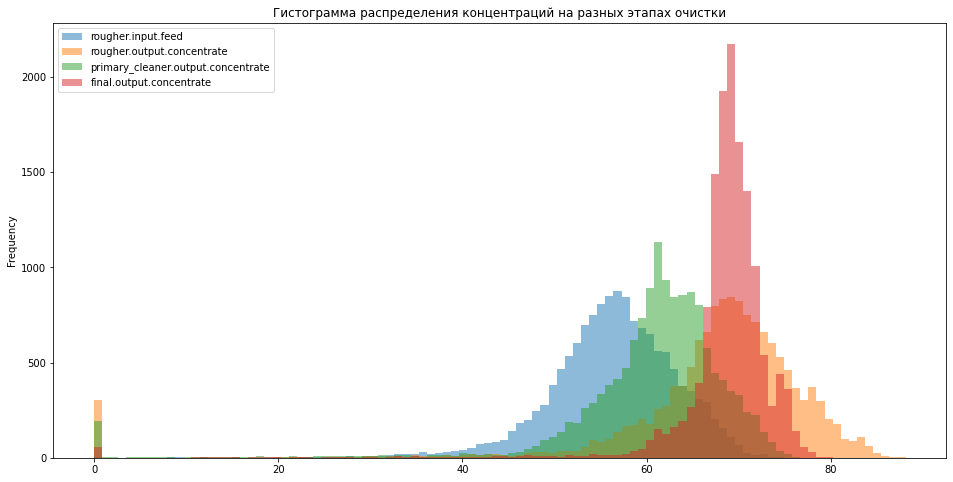

In [12]:
for metric in CONCENTRATE_METRICS:
    train_df[metric] = 0
    for metal in METALS + ['sol']:
        train_df[metric] += train_df[f'{metric}_{metal}']

train_df[CONCENTRATE_METRICS].plot(kind='hist', alpha=0.5, figsize=(16, 8), bins=100, title='Гистограмма распределения концентраций на разных этапах очистки')

В данных наблюдается множество выбросов: распределения сильно скошены влево, а также мы видим много нулевых значений.

Построим гистограммы и диаграммы размаха для каждого признака. После этого избавимся от аномильных значений, определив границы нормального распределения (т.е. Q1 - 1.5*IQR и Q3 + 1.5*IQR). И еще раз посмотрим на диаграмму распределения каждого из признаков, как она изменилась.

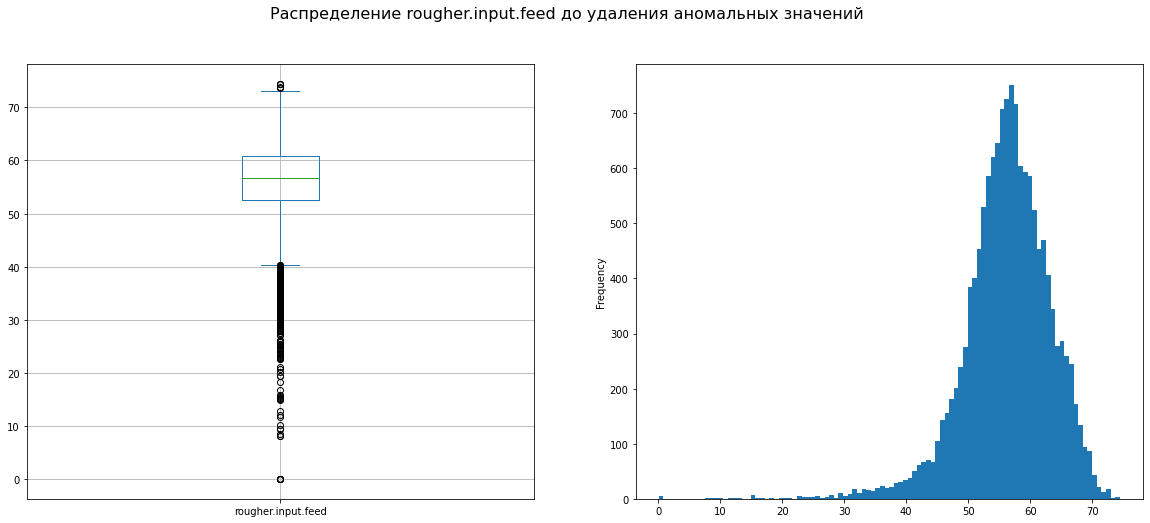

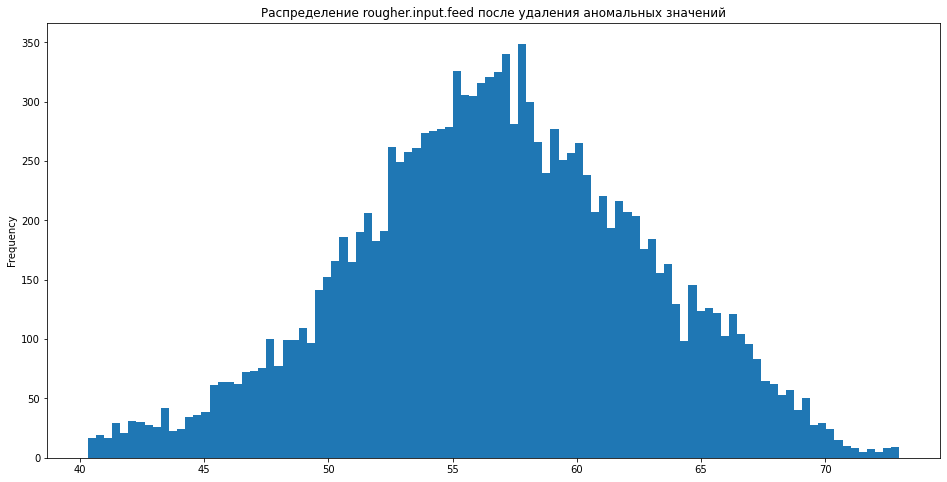

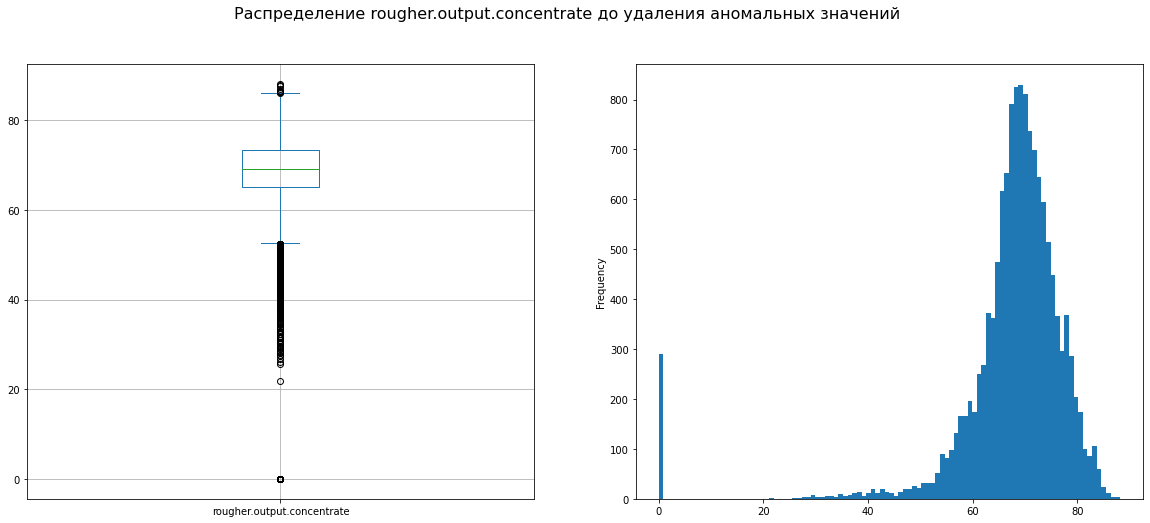

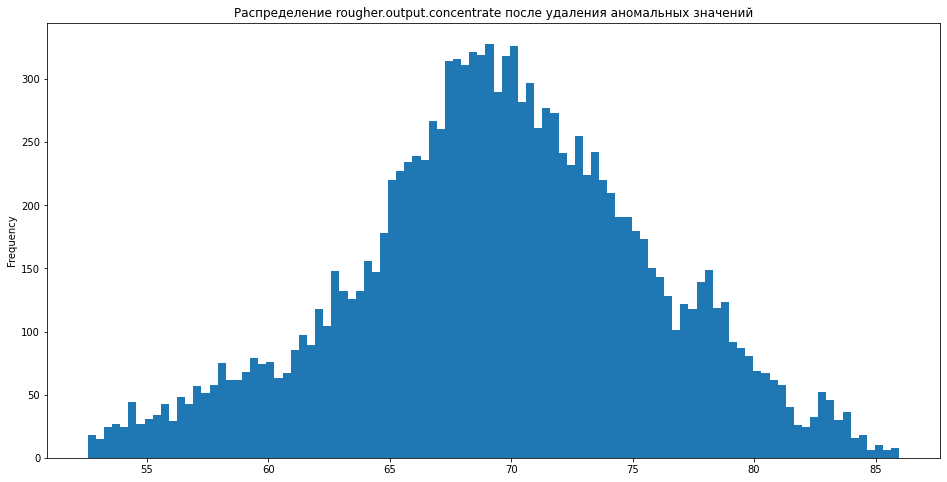

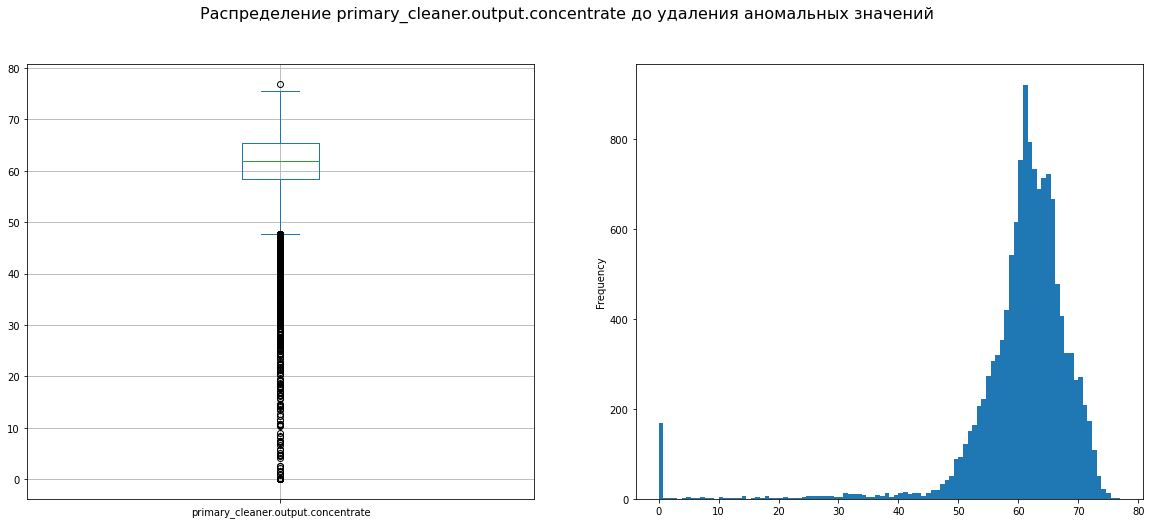

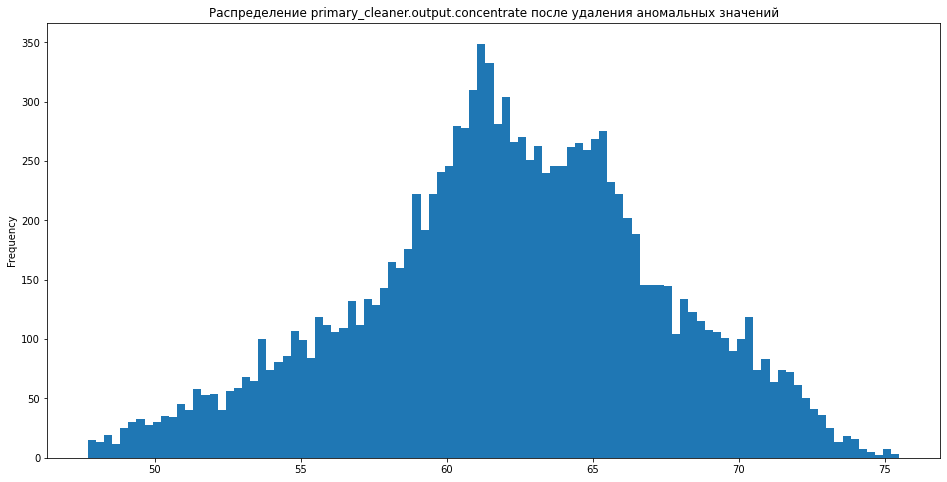

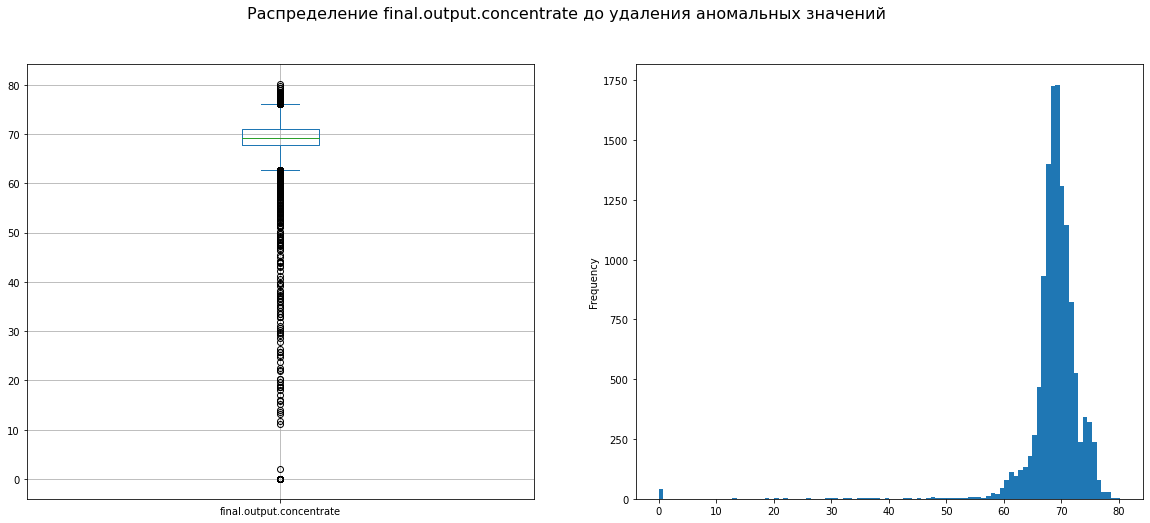

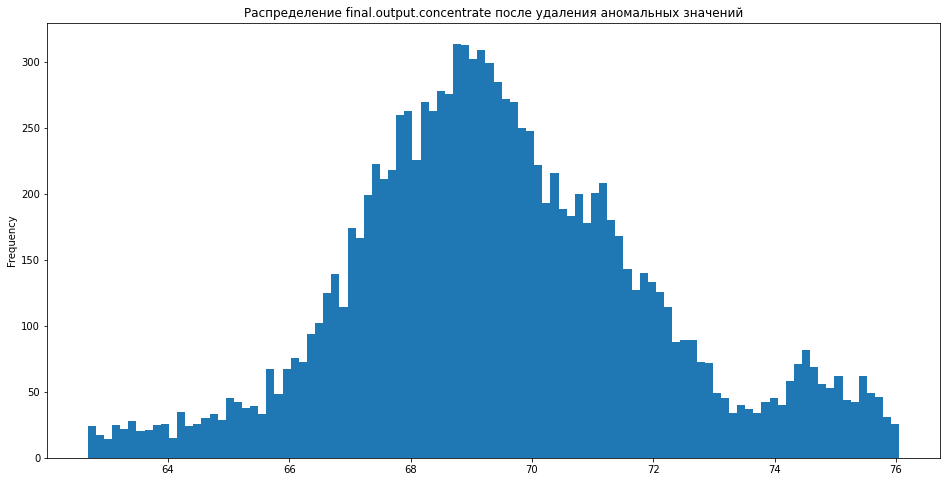

In [13]:
def get_whiskers(dataset):
    q_1 = dataset.quantile(0.25)
    q_3 = dataset.quantile(0.75)
    iqr = q_3 - q_1
    left_whisker = q_1 - 1.5 * iqr
    right_whisker = q_3 + 1.5 * iqr
    return (
        max(dataset.min(), left_whisker),
        min(dataset.max(), right_whisker)
    )

for metric in CONCENTRATE_METRICS:
    dataset = train_df[metric]
    fig, axes = plt.subplots(1, 2, figsize=(20,8))
    dataset.plot(kind='box', grid=True, ax=axes[0])
    dataset.plot(kind='hist', bins=100, ax=axes[1])
    fig.suptitle(f'Распределение {metric} до удаления аномальных значений', fontsize=16)
    plt.show()
    l_whisker, r_whisker = get_whiskers(dataset)
    train_df = train_df[(dataset > l_whisker) &  (dataset < r_whisker)]
    train_df[metric].plot(kind='hist', bins=100, figsize=(16,8), title=f'Распределение {metric} после удаления аномальных значений')
    plt.show()

**Вывод**
После удаления аномальных значений распределение стало симметричным. Мы не будем удалять выбросы на тестовой выборке, потому что они никак не могут повлиять на адекватность нашей модели.

## Построение модели

### Функцию для вычисления итоговой sMAPE
Напишем функцию для вычисления итоговой sMAPE.

In [14]:
def smape(target, predictions):
    numerator = np.abs(target - predictions)
    denominator = (np.abs(target) + np.abs(predictions)) / 2
    return 1 / len(target) * np.sum(numerator / denominator) * 100

def final_smape(target, predictions):
    target_rougher = target['rougher.output.recovery']
    target_final = target['final.output.recovery']

    predictions_rougher = predictions[:, 0]
    predictions_final = predictions[:, 1]

    smape_rougher = smape(target_rougher, predictions_rougher)
    smape_final = smape(target_final, predictions_final)

    return 0.25 * smape_rougher + 0.75 * smape_final

Создадим scorer, чтобы испольщовать его при кросс-валидации.

In [15]:
smape_scorer = make_scorer(final_smape, greater_is_better=False)

### Подготовка данных

Выделим фичи и целевые признаки для обучающей и тестовой выборки.

In [16]:
features_test = test_df.drop([*TARGETS, 'date'], axis=1)
features_train = train_df[features_test.columns]
target_train = train_df[TARGETS]
target_test = test_df[TARGETS]

print(f'Размер train датасетов: {features_train.shape} и {target_train.shape}')
print(f'Размер test датасетов: {features_test.shape} и {target_test.shape}')

Размер train датасетов: (11855, 52) и (11855, 2)
Размер test датасетов: (5290, 52) и (5290, 2)


Чтобы избежать ловушки, когда алгоритм решит, что один признак важнее другого, признаки масштабируются — приводятся к одному масштабу. Стандартизируем признаки с помощью `StandardScaler`.

In [17]:
scaler = StandardScaler()

scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### Обучение разных моделей

Перед нами стоит задача регресии. Выберем следующие модели для обучения:
- DecisionTreeRegressor (с подбором гиперпараметров)
- RandomForestRegressor (с подбором гиперпараметров)
- LinearRegression

и найдем лучшую среди них.

**Дерево решений**

In [18]:
param_grid = {'max_depth': range(2, 11)}

model = DecisionTreeRegressor(random_state=RANDOM_STATE)
search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
search.fit(features_train, target_train)
print(f'Лучшее значение sMAPE для DecisionTreeRegressor: {np.abs(search.best_score_)} при гиперпараметрах: {search.best_params_}')

Лучшее значение sMAPE для DecisionTreeRegressor: 8.377004234891576 при гиперпараметрах: {'max_depth': 2}


**Cлучайный лес**

In [19]:
param_grid = {'n_estimators': range(10, 30, 10), 'max_depth': range(2, 5)}

model = RandomForestRegressor(random_state=RANDOM_STATE)
search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
search.fit(features_train, target_train)
print(f'Лучшее значение sMAPE для RandomForestRegressor: {np.abs(search.best_score_)} при гиперпараметрах: {search.best_params_}')

Лучшее значение sMAPE для RandomForestRegressor: 8.25063256068365 при гиперпараметрах: {'max_depth': 2, 'n_estimators': 20}


**Линейная регрессия**

In [20]:
model = LinearRegression()
model.fit(features_train, target_train)
smape_score = cross_val_score(model, features_train, target_train, cv=5, scoring=smape_scorer).mean()
print(f'Лучшее значение sMAPE для линейной регрессии: {np.abs(smape_score)}')

Лучшее значение sMAPE для линейной регрессии: 8.971486213193348


Модель случайного леса дала самый лучший результат. Проверим эту модель на тестовой подборке с соответствующими гиперпараметрами.

### Проверка на тестовой выборке

In [21]:
model = RandomForestRegressor(max_depth=2, n_estimators=20, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print('sMAPE для тестовых данных:', final_smape(target_test, predictions_test))

sMAPE для тестовых данных: 8.752408487597734


На тестовой выборке модель дала немного хуже результат. Но давайте сравним его с sMAPE константной модели (все предсказания заполним медианой).

### Сравнение с константой моделью

In [22]:
base = DummyRegressor(strategy="median")
base.fit(features_train, target_train)
base_predictions = base.predict(features_test)
print('sMAPE для константной модели', final_smape(target_test, base_predictions))

sMAPE для константной модели 9.346049686218173


Тем не менее модель случайного леса предсказывает немного лучше.

### Вывод
случайный лес дал лучшее значение sMAPE среди других моделей
на тестовой выборке случайный лес предсказал значения целевых признаков rougher.output.recovery и final.output.recovery с sMAPE 8.7